In [78]:

import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# from mpl_toolkits.basemap import Basemap
import glob
from netCDF4 import Dataset
import copy
import gc

import os
import sys
# sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import grid_set as gs

import ant_plus
from imp import reload
reload(ant_plus)
reload(gs)

<module 'grid_set' from '/Users/h/PREMELT/Ant+/grid_set.py'>

In [2]:
#$### map projection
m = ccrs.SouthPolarStereo()
proj_cart = ccrs.PlateCarree() 
f = plt.figure()
G= gs.grid_set(m)

ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
G.set_grid_dxy(50e3,50e3,ax)
plt.close()


Got a grid res =  185  x  185
Note that all grid info is in nx x ny grids, whilst data is in nx x ny


In [79]:
# file = 'Example_Merge/Open_ocean_ANOM_2019-09-01T00-03_2019-09-03T23-26.nc'
file = '/Users/h/PREMELT/Ant+/Comb_files_for_Stine/DOT_SLA_whole_anto_2019-03-01T00-40_2019-03-31T23-15.nc'
track=ant_plus.CS2_track(file,add_attr=True)
# track.print_time()

In [80]:
### makes a directory for figures
fig_dir = file.split('.nc')[0]+'/'
check_dir = os.path.dirname(fig_dir)
if not os.path.exists(check_dir):
    os.makedirs(check_dir)

In [81]:
track.list_vars()#['ANOM','flag',])

['time_20_ku',
 'lon_20_ku',
 'lat_20_ku',
 'range_1_20_ku',
 'range_1_20_ku_ANOM_ISat_2step',
 'range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice',
 'range_1_20_ku_ANOM_DTU_imp_th70',
 'range_1_20_ku_ANOM_DTU_th70',
 'range_1_20_ku_ANOM_DTU_gauss',
 'range_1_20_ku_ANOM_MSSL_D',
 'range_1_20_ku_ANOM_MSSL_S',
 'range_1_20_ku_ANOM_LEGOS_GPOD_All',
 'range_1_20_ku_ANOM_CLS',
 'mean_sea_surf_20_ku_ANOM_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU21',
 'atm_geo_corrections_sum_ANOM_ISat',
 'atm_geo_corrections_sum_ANOM_LEGOS_GPOD',
 'mean_sea_surf_sea_ice_20_ku',
 'geoid_20_ku',
 'height_1_20_ku',
 'flag_surf_type_class_20_ku',
 'flag_surf_type_20_ku_CLS',
 'flag_surf_type_20_ku_LEGOS_GPOD',
 'NSIDC_nasa']

In [82]:
load_list = track.list_vars(['ANOM','flag','height','geoid','mean_sea_surf_sea_ice_20_ku'])
# load_list = track.list_vars(['mean_sea_surf_sea_ice_20_ku'])
track.add_vars(load_list)

In [83]:
# track.mean_sea_surf_20_ku_ANOM_DTU15_attr
# track.range_1_20_ku_ANOM_CLS_LEAD_attr
# track.flag_surf_type_class_20_ku_attr
track.mean_sea_surf_sea_ice_20_ku_attr

{'comment': 'Mean sea surface model, referenced to the WGS84 ellipsoid. This model has been optimised for use in computing the surface height anomaly of the polar oceans to derive sea-ice freeboard. The model is a merge of the CLS2011 mean sea-surface and CryoSat data from high latitudes.',
 'coordinates': 'lon_20_ku lat_20_ku',
 'institution': 'UCL',
 'long_name': 'mean sea surface height above reference ellipsoid',
 'source': 'UCL13',
 'standard_name': 'sea_surface_height_above_reference_ellipsoid',
 'units': 'm'}

In [85]:
track.range = '-'.join([
    ant_plus.CSt2dt(track.time_20_ku[0]).strftime('%Y%m%d'),
    ant_plus.CSt2dt(track.time_20_ku[-1]).strftime('%Y%m%d')])
track.range

'20190301-20190331'

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a

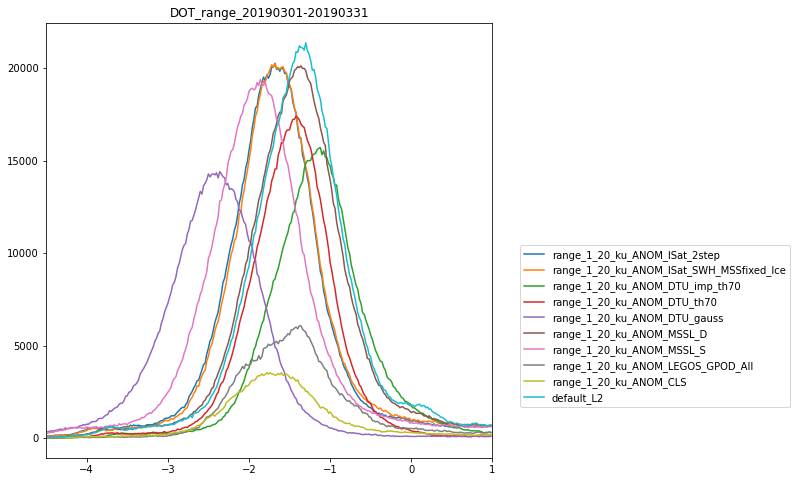

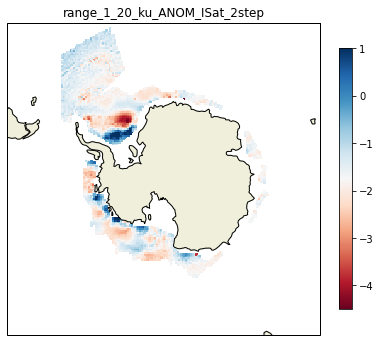

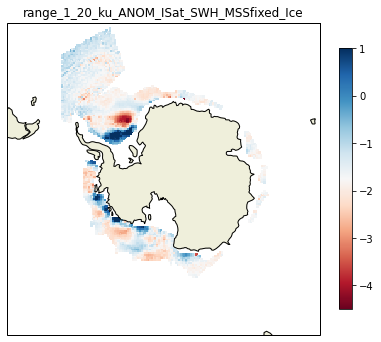

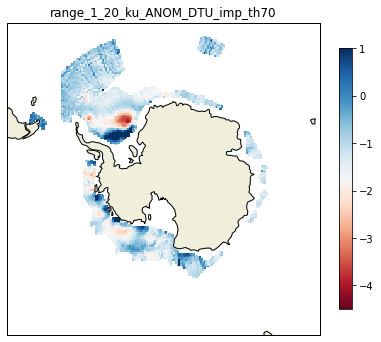

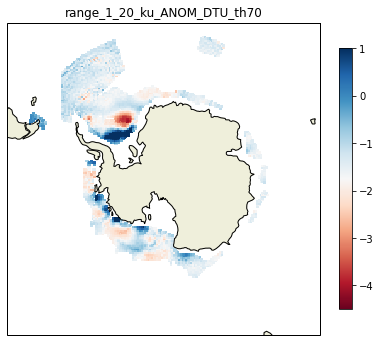

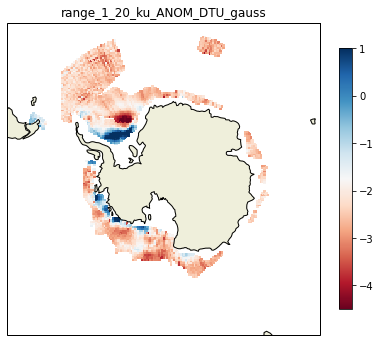

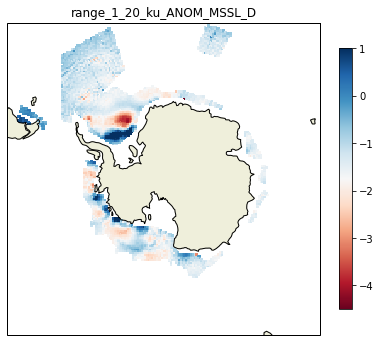

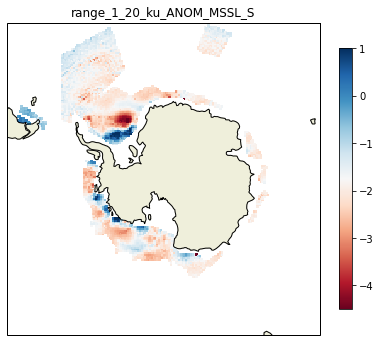

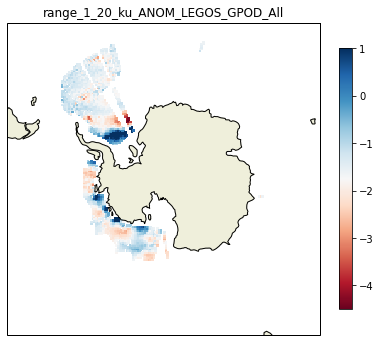

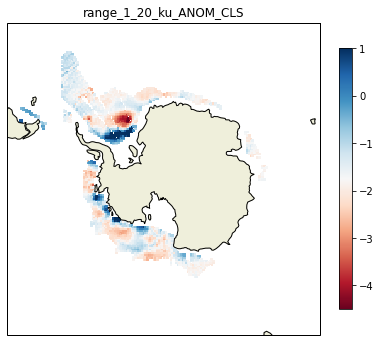

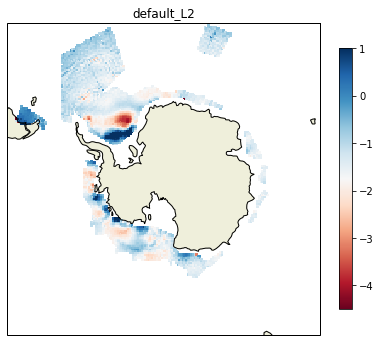

In [93]:
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
p_vars = [p for p in track.vars if 'ANOM' in p and 'range' in p ]
# p_vars = [p for p in track.vars if 'ANOM' in p and 'atm' in p ]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'flag' in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
SaveT = 'DOT_range_' ### name for the figure
extra_hist = False
p_vars = p_vars+['default_L2'] #### extra for not adding an anomally
h_auto = False ## h_(min,max) calculated from data range
h_sym = False ## h_(min,max) forced to symmetric about 0
h_trim = False ### centiles to knock off, set the percentiles to remove
# h_trim = 1 ### takes away the 5 and 95 percentile before binning/histogram
h_min = -4.5
h_max =  1.0
# h_min = 0.9
# h_max =  3.1
hard_min = -10.0 ### extras to remove crazy outliers
hard_max =  10.0
#### surface type options
LG_CLS_flag = [1,3] ### for CLS and legos 2 => sea_ice
L2_flag = [64,256]
#### a mask is always require from Bl-D L2
# msk = track.flag_surf_type_class_20_ku ==  128 ### sea ice
# msk[track.flag_surf_type_class_20_ku ==  64] = True ### also ocean
h_bins = np.arange(h_min,h_max,0.02)
### Fall combined histogram

fall = plt.figure(figsize=[8,8])
axall = fall.add_subplot(1,1,1)
for v in p_vars:
    msk = np.ones_like(track.time_20_ku,dtype=bool) ### all data
    if 'default' in v: #### to make DOT
        x = track.height_1_20_ku - track.geoid_20_ku
    else:
        x = getattr(track,v).copy()
        #### to make DOT
        x = -x + track.height_1_20_ku - track.geoid_20_ku
    #### extra masking
    if 'GPOD' in v:
        ### leads and ocean
        for fflag in LG_CLS_flag:
            msk[track.flag_surf_type_20_ku_LEGOS_GPOD==fflag] = 1
    elif 'CLS' in v:
        for fflag in LG_CLS_flag:
            msk[track.flag_surf_type_20_ku_CLS==fflag] = 1
    else:
        for fflag in L2_flag:
            msk[track.flag_surf_type_class_20_ku==fflag] = 1
#     if 'class' in v:
#         x[x<64] = 0
#         x[x==256] = 3
#         x[x==128] = 2
#         x[x==64] = 1
    x[x.mask] = np.nan
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    if h_trim:
        h_t0,h_t1 = np.nanpercentile(x[msk],[h_trim,100-h_trim])
        msk[x>h_t1] = 0
        msk[x<h_t0] = 0
        
    x = x[msk]
        
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0)
#                              bin_func = func_u)
    if h_auto:
        h_min,h_max = np.nanpercentile(x,[0.5,99.5])
        if h_sym:
            h_max = np.maximum(np.abs(h_min),np.abs(h_max))
            h_min = -h_max
        h_bins = np.arange(h_min,h_max,(h_max-h_min)/50)

    if extra_hist:
        y_fig = 14
        fno = 2
    else:
        y_fig = 7
        fno = 1
    f = plt.figure(figsize=[y_fig,6])
    ax = f.add_subplot(1,fno,1,projection=m)
    ax.set_extent([-180, 180, -90, -50], proj_cart)
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.set_title(v)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.8,pad=0.05)
    
    hist = np.histogram(x,bins=h_bins)[0]
#     ax.plot(h_bins[:-1] + np.diff(h_bins),hist,'-k')
    if extra_hist:
        ax = f.add_subplot(1,2,2)
        ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
        ax.set_ylim([h_min,h_max])
        ax.set_ylabel(v)
    f.savefig(fig_dir+SaveT+v+'_map_hist.png',bbox_inches='tight')
    f.show()
#     ax.plot(h_bins[:-1] + np.diff(h_bins),hist,'-k')
    axall.plot(h_bins[:-1] + np.diff(h_bins),hist,label = v)
axall.set_xlim([h_min,h_max])
axall.legend(bbox_to_anchor =(1.05, 0.5))
axall.set_title(SaveT+track.range)
fall.show()
fall.savefig(fig_dir+SaveT+track.range+'_all_hist.png',bbox_inches='tight')

/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/h/.local/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


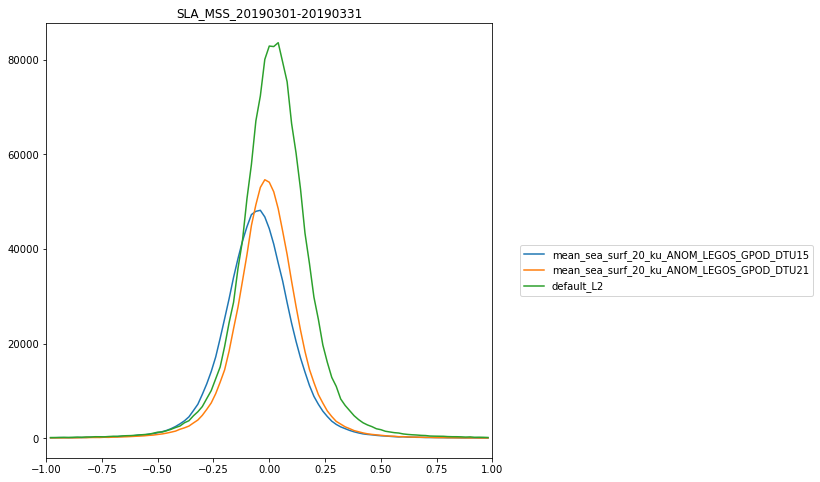

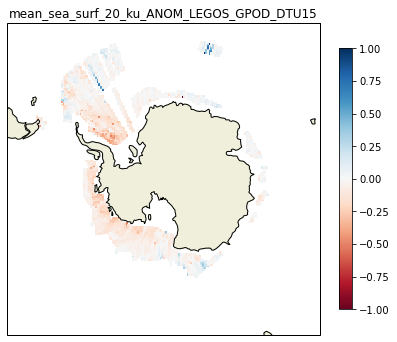

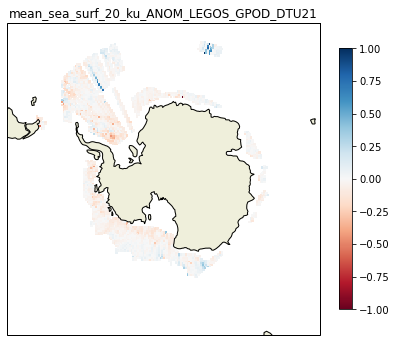

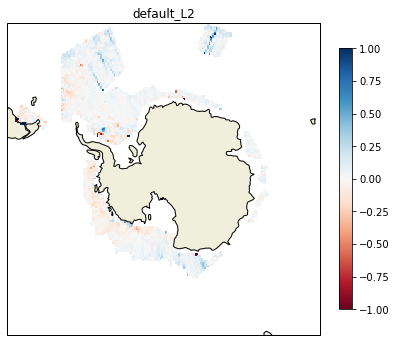

In [92]:
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'ANOM' in p and 'range' in p ]
# p_vars = [p for p in track.vars if 'ANOM' in p and 'atm' in p ]
p_vars = [p for p in track.vars if 'ANOM' in p and 'mean' in p ]
p_vars = [p for p in p_vars if 'LEGOS' in p]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'flag' in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
SaveT = 'SLA_MSS_' ### name for the figure
extra_hist = False
p_vars = p_vars+['default_L2'] #### extra for not adding an anomally
h_auto = False ## h_(min,max) calculated from data range
h_sym = False ## h_(min,max) forced to symmetric about 0
h_trim = False ### centiles to knock off, set the percentiles to remove
# h_trim = 1 ### takes away the 5 and 95 percentile before binning/histogram
h_min = -1.0
h_max =  1.0
# h_min = 0.9
# h_max =  3.1
hard_min = -10.0 ### extras to remove crazy outliers
hard_max =  10.0
#### surface type options
LG_CLS_flag = [1,3] ### for CLS and legos 2 => sea_ice
L2_flag = [64,256]
#### a mask is always require from Bl-D L2
# msk = track.flag_surf_type_class_20_ku ==  128 ### sea ice
# msk[track.flag_surf_type_class_20_ku ==  64] = True ### also ocean
h_bins = np.arange(h_min,h_max,0.02)
### Fall combined histogram

fall = plt.figure(figsize=[8,8])
axall = fall.add_subplot(1,1,1)
for v in p_vars:
    msk = np.ones_like(track.time_20_ku,dtype=bool) ### all data
    if 'default' in v: #### to make DOT
        x = track.height_1_20_ku - track.mean_sea_surf_sea_ice_20_ku
    else:
        x = getattr(track,v).copy()
        #### to make DOT
        x = -x + track.height_1_20_ku - track.mean_sea_surf_sea_ice_20_ku
    #### extra masking
    if 'GPOD' in v:
        ### leads and ocean
        for fflag in LG_CLS_flag:
            msk[track.flag_surf_type_20_ku_LEGOS_GPOD==fflag] = 1
    elif 'CLS' in v:
        for fflag in LG_CLS_flag:
            msk[track.flag_surf_type_20_ku_CLS==fflag] = 1
    else:
        for fflag in L2_flag:
            msk[track.flag_surf_type_class_20_ku==fflag] = 1
#     if 'class' in v:
#         x[x<64] = 0
#         x[x==256] = 3
#         x[x==128] = 2
#         x[x==64] = 1
    x[x.mask] = np.nan
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    if h_trim:
        h_t0,h_t1 = np.nanpercentile(x[msk],[h_trim,100-h_trim])
        msk[x>h_t1] = 0
        msk[x<h_t0] = 0
        
    x = x[msk]
        
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0)
#                              bin_func = func_u)
    if h_auto:
        h_min,h_max = np.nanpercentile(x,[0.5,99.5])
        if h_sym:
            h_max = np.maximum(np.abs(h_min),np.abs(h_max))
            h_min = -h_max
        h_bins = np.arange(h_min,h_max,(h_max-h_min)/50)

    if extra_hist:
        y_fig = 14
        fno = 2
    else:
        y_fig = 7
        fno = 1
    f = plt.figure(figsize=[y_fig,6])
    ax = f.add_subplot(1,fno,1,projection=m)
    ax.set_extent([-180, 180, -90, -50], proj_cart)
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.set_title(v)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=0.8,pad=0.05)
    
    hist = np.histogram(x,bins=h_bins)[0]
#     ax.plot(h_bins[:-1] + np.diff(h_bins),hist,'-k')
    if extra_hist:
        ax = f.add_subplot(1,2,2)
        ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
        ax.set_ylim([h_min,h_max])
        ax.set_ylabel(v)
    f.savefig(fig_dir+SaveT+v+'_map_hist.png',bbox_inches='tight')
    f.show()
#     ax.plot(h_bins[:-1] + np.diff(h_bins),hist,'-k')
    axall.plot(h_bins[:-1] + np.diff(h_bins),hist,label = v)
axall.set_xlim([h_min,h_max])
axall.legend(bbox_to_anchor =(1.05, 0.5))
axall.set_title(SaveT+track.range)
fall.show()
fall.savefig(fig_dir+SaveT+track.range+'_all_hist.png',bbox_inches='tight')

In [57]:
for v in track.vars:
    if 'range' in v and 'ANOM' in v:
#     if 'range' in v and 'ISat' in v:
#     if 'geoi' in v:
#     if 'ANOM' in v:
        print('-----')
        print(v)
        print('-----')
        if hasattr(track,v+'_attr'):
            attr = getattr(track,v+'_attr')
            for key, value in attr.items():
                print(key, ' : ', value)
        x = copy.copy(getattr(track,v))
        if type(x.mask) == np.ndarray:
            x[x.mask] = np.nan
        print('Distribution of '+v+' = '+' , '.join('{:.3}'.format(pc) for pc in np.nanpercentile(x,[25,50,75])))

-----
range_1_20_ku_ANOM_ISat_2step
-----
Description  :  Anomaly from L2 range to _ISat_2step retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_ISat_2step = 0.184 , 0.258 , 0.346
-----
range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice
-----
Description  :  Anomaly from L2 range to _ISat_SWH_MSSfixed_Ice retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice = 0.141 , 0.253 , 0.346
-----
range_1_20_ku_ANOM_DTU_imp_th70
-----
Description  :  Anomaly from L2 range to _DTU_imp_th70 retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_DTU_imp_th70 = -0.302 , -0.184 , -0.116
-----
range_1_20_ku_ANOM_DTU_th70
-----
Description  :  Anomaly from L2 range to _DTU_th70 retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_DTU_th70 = 0.012 , 0.0444 , 0.0867
-----
